<b><h1 align=center>Lane Line Detection</h1></b>  


# White Color Selection  

In [3]:
!pip3 install opencv-python

In [4]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
#used to read an image and store it in a numpy array
import matplotlib.image as mpimg  
#To make sure that plots are displayed in the output cell
%matplotlib inline  
#Cv2 from OpenCV(Open Source Computer Vision) is a computer vision library which we are using to read images, process them for lane detection and then display them. 
import os
os.sys.path
import cv2


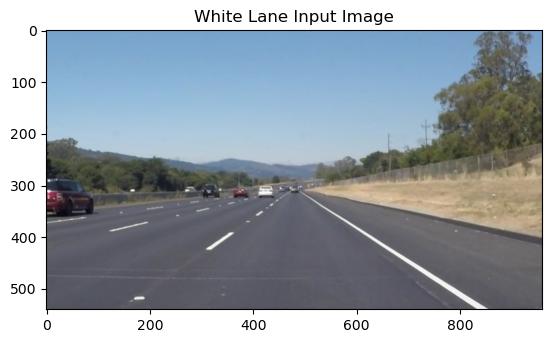

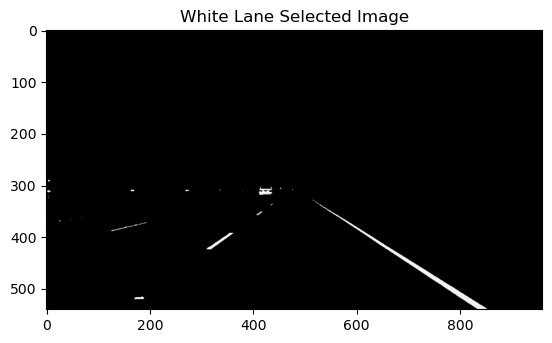

In [5]:
# detect white lines by loading image for that in a numpy array 
white_image = mpimg.imread('/Users/naeem/Desktop/Images/solidWhiteRight.jpg')
#/Users/naeem/Desktop/solidWhiteRight.jpg

# We get the height and width of the image from the shape attribute of numpy array
height = white_image.shape[0]
width = white_image.shape[1]

#create a copy of the original image for processing
white_detect = np.copy(white_image)

# White colour is RGB(255,255,255). We take a minimum threshold of (200,200,200) to detect white lanes.
red = 200
green = 200
blue = 200
rgb_threshold = [red, green, blue]

# We mask out the pixels below the threashold. Thus, entire picture except the white lanes will be black
thresholds = (white_image[:,:,0] < rgb_threshold[0]) \
            | (white_image[:,:,1] < rgb_threshold[1]) \
            | (white_image[:,:,2] < rgb_threshold[2])
white_detect[thresholds] = [0,0,0]

# Displaying the original and processed image
plt.imshow(white_image)
plt.title("White Lane Input Image")
plt.show()
plt.imshow(white_detect)
plt.title("White Lane Selected Image")
plt.show()

# Region Masking  


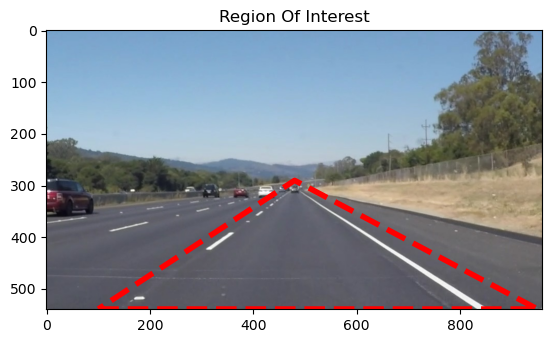

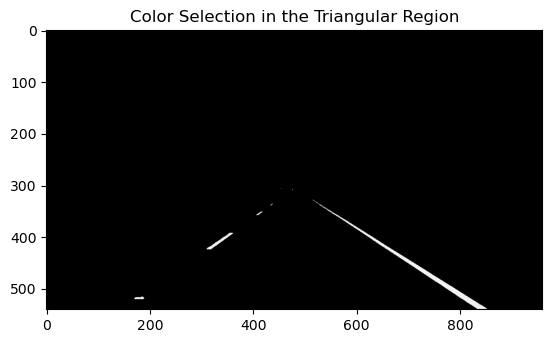

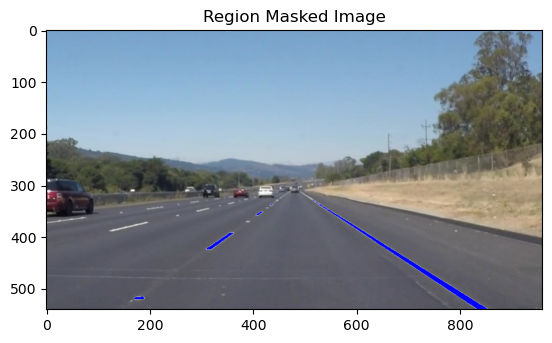

In [6]:
# detect region for white lines by loading image for that in a numpy array 
white_image = mpimg.imread('/Users/naeem/Desktop/Images/solidWhiteRight.jpg')

# We get the height and width of the image from the shape attribute of numpy array
height = white_image.shape[0]
width = white_image.shape[1]

#create 2 copies of the original image for processing
line_detect = np.copy(white_image)
region_detect = np.copy(white_image)

# For line detection: White colour is RGB(255,255,255). We take a minimum threshold of (200,200,200) to detect white lanes.
red = 200
green = 200
blue = 200
rgb_threshold = [red, green, blue]

# For Region of interest (ROI): define a triangular region using the 2 base points and apex
left = [100, 539]
right = [950, 539]
apex = [480, 290]

# np.polyfit is a NumPy function that fits a linear function (Y=AX+B) to each side of the triangle by unsing the datapoints and returns [A,B] of the fit
leftLine = np.polyfit((left[0], apex[0]), (left[1], apex[1]), 1)
rightLine = np.polyfit((right[0], apex[0]), (right[1], apex[1]), 1)
bottomLine = np.polyfit((left[0], right[0]), (left[1], right[1]), 1)

# We mask out the pixels below the thresshold. Thus, entire picture except the white lanes will be black
color_thresholds = (white_image[:,:,0] < rgb_threshold[0]) | \
                    (white_image[:,:,1] < rgb_threshold[1]) | \
                    (white_image[:,:,2] < rgb_threshold[2])

# We Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, width), np.arange(0, height))
region_thresholds = (YY > (XX*leftLine[0] + leftLine[1])) & \
                    (YY > (XX*rightLine[0] + rightLine[1])) & \
                    (YY < (XX*bottomLine[0] + bottomLine[1]))
                    
# Mask color and region selection, All image black except that
line_detect[color_thresholds | ~region_thresholds] = [0, 0, 0]

# Color pixels blue where both color and region selections met
region_detect[~color_thresholds & region_thresholds] = [0, 0, 255]

# Display the original image with our Region of Interest outlined Red (3 points bottomleft, bottomright and apex defined above) 
plt.imshow(white_image)
x = [left[0], right[0], apex[0], left[0]]
y = [left[1], right[1], apex[1], left[1]]
plt.plot(x, y, 'r--', lw=4)
plt.title("Region Of Interest")
plt.show()

#Display the picture in which we mask out all other areas except lines
plt.imshow(line_detect)
plt.title("Color Selection in the Triangular Region")
plt.show()

#Display the picture with lanes in region green
plt.imshow(region_detect)
plt.title("Region Masked Image")
plt.show()

## Edge Detection  

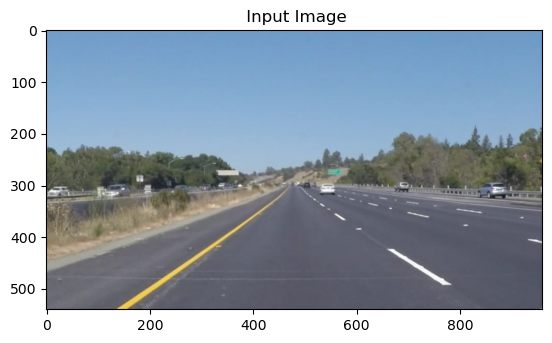

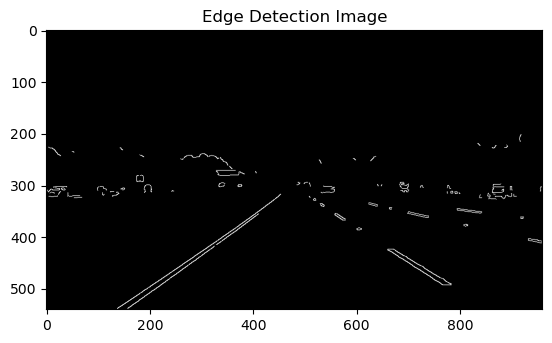

In [7]:
# For canny edge detection read the image in a numpy array and convert it to grayscale using cv2.cv2Color
image = mpimg.imread('/Users/naeem/Desktop/Images/solidYellowLeft.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# We apply Guassian blur to smooth the image and reduce noise so proper edge detection can be done
# kernel size for Gaussian smoothing/ blurring defines how much smoothing to be done
kernel = 5
guassian = cv2.GaussianBlur(gray,(kernel, kernel),0)

# Canny Filter applied 
low_threshold = 180
high_threshold = 240
canny = cv2.Canny(guassian, low_threshold, high_threshold)

# Display the image
plt.imshow(image)
plt.title(" Input Image")
plt.show()
plt.imshow(canny, cmap='Greys_r')
plt.title("Edge Detection Image")
plt.show()

## Hough Transform

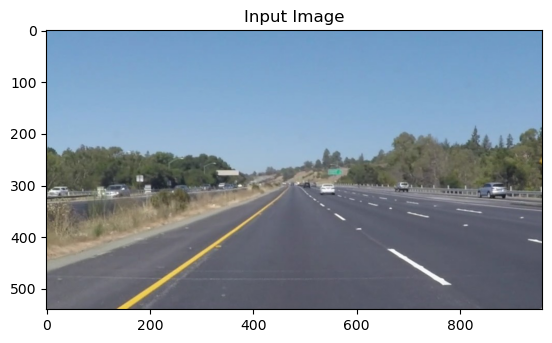

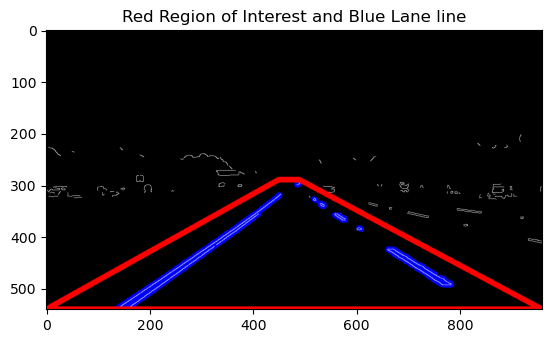

In [8]:
# Load image and grayscale it 
image = mpimg.imread('/Users/naeem/Desktop/Images/solidYellowLeft.jpg')
gray_scale = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Apply Guassian smoothing/blurring
kernel = 5
guassian_blur = cv2.GaussianBlur(gray_scale,(kernel, kernel),0)

# Apply Canny Detection
low_threshold = 180
high_threshold = 240
edges = cv2.Canny(guassian_blur, low_threshold, high_threshold)

# Create a masked edges image using cv2.fillPoly(). Four sided polygon is masked 
#mask colour
mask = np.zeros_like(edges)   
ignore_mask_color = 255   
#mask shape
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

# Hough Transformation
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 2     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 4 #minimum number of pixels making up a line
max_line_gap = 5    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

#Hough function from cv2
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)

# The hough lines are drawn on a blank image 
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
lines_edges = cv2.polylines(lines_edges,vertices, True, (255,0,0), 10)
plt.imshow(image)
plt.title("Input Image")
plt.show()
plt.imshow(lines_edges)
plt.title("Red Region of Interest and Blue Lane line")
plt.show()

# Lane Detection  


In [9]:
# convert the given image to grayscale using cv2.cv2.color
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# apply guassian blur
def gaussianBlur(image, kernel):
    return cv2.GaussianBlur(image, (kernel, kernel), 0)
 
# apply canny edge detection
def cannyEdgeDetection(image, low_threshold, high_threshold):
    return cv2.Canny(image, low_threshold, high_threshold)

# Takes image and a set of vertices, and returns a masked image that only shows the region of interest defined by the vertices
def regionOfInterest(image, vertices):
    
    #a blank mask is created having the same shape as imput image, np.zeros is for blank 0 mask, _like is for same shape as image
    mask = np.zeros_like(image)   
    
    # If it has more than 1 channel it is a coloured image so ignore mask size is according to the number of channels 
    if len(image.shape) > 2:
        no_of_channels = image.shape[2] 
        ignore_mask = (255,) * no_of_channels
    # If only 1 channel it is a gray scale image and we simply set ignore mask to a scalar value 255
    else:
        ignore_mask = 255
        
    # We fill the ignore mask region identified above with our fill colour "mask" which we defined to be black above  
    cv2.fillPoly(mask, vertices, ignore_mask)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image


# Function takes an image and draws hough lines on it 
def houghLines(image, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    line_img = extrapolateSlopeLines(line_img,lines)
    return line_img

# Helper function that draws the line provided on to the input image with the mentioned colour and thickness
def drawLines(image, lines, color=[255, 0, 0], thickness=10):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)

#Helper fucntion that takes a set of slope lines and extrapolates them according to the region of interest
def extrapolateSlopeLines(image,lines):
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]
     
    #Filter the input lines into tow sets left_lines (/: negative slope to the left), right_lines (\: positive slope to the right)
    left_lines = [] 
    right_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 == x2:             #ignore the vertical lines 
                pass 
            else:                    #calculate gradient/slope
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1
                #If negative slope append in left_lines else append in right_lines
                if m < 0:
                    left_lines.append((m,c))
                elif m >= 0:
                    right_lines.append((m,c))
                    
    # Calculate the average slope and intercept for left and right lines
    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    #Use the average slope and intercept to extrapolate the left and right lane lines from the bottom of the image to the top of the region of interest.
    for slope, intercept in [left_line, right_line]:

        #getting complete height of image in y1
        height=image.shape[0]
        width= image.shape[1]
        y1= int(height)

        #taking y2 upto 60% of actual height/ y1 to extrapolate the lines
        y2= int(0.6*y1) 

        #Equation of line is y=mx +c so we can write it x=(y-c)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        
        #Draw the extrapolated lines using draw_lines helper function
        drawLines(img, np.array([[[x1,y1,x2,y2]]]))
    
    poly_vertices = [poly_vertices[i] for i in order]
    
    #Fill the region of interest with blue colour using openCV fillPolly function
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,0,255))
    
    #blends the resulting image with the original image using OpenCV's addWeighted function.
    return cv2.addWeighted(image,0.7,img,0.4,0.)


#Helper function that takes 2 input images and 3 weight coefficients, α, β, and γ and blend the images with cv2 function addWeighted  
# New image=  initial_img * α + img * β + γ
def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    return lines_edges

#Helper function to return vertices of the image provided in a numpy array
def getVertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.6]
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.6] 
    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

In [10]:
def lane_detection(image):
    grayScale = grayscale(image)
    guassian_image = gaussianBlur(grayScale, 5)                          #parameters(image, kernel)
    canny_image = cannyEdgeDetection(guassian_image, 180, 240)          #paramteres(image, low_threshold, high_threshold
    masked_image = regionOfInterest(canny_image, getVertices(image))    #parameters(image, vertices)
    houghed_image = houghLines(image = masked_image, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    output = weighted_img(houghed_image, image, 0.8,1.,0.)  #parameters(img, initial_img, α, β, γ)
    return output

# Testing

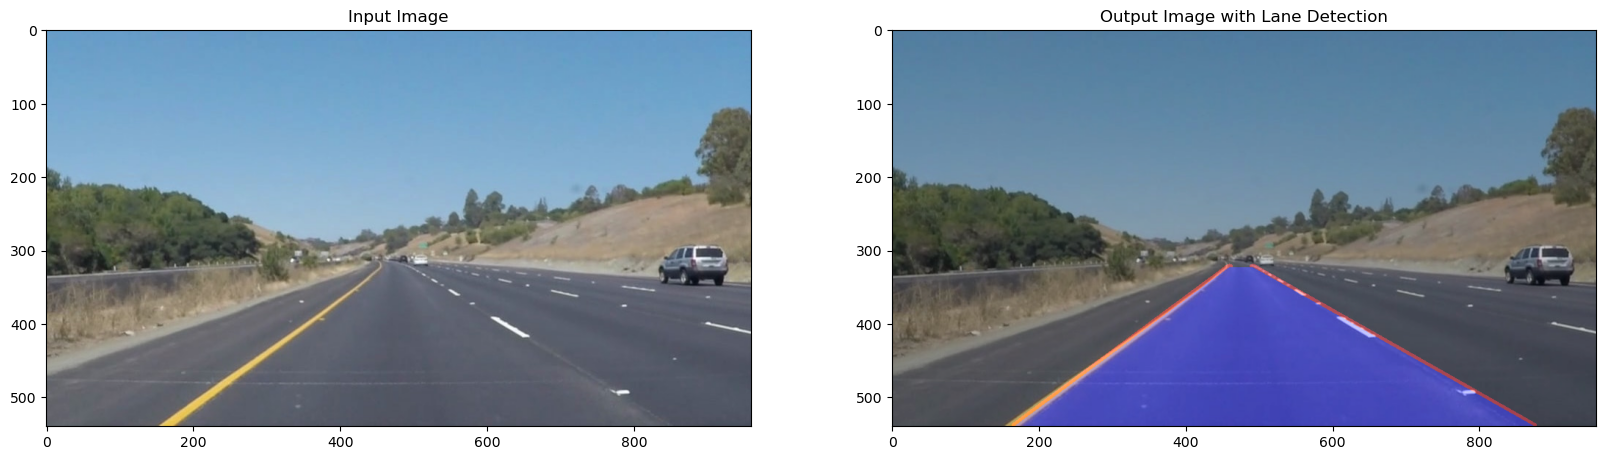

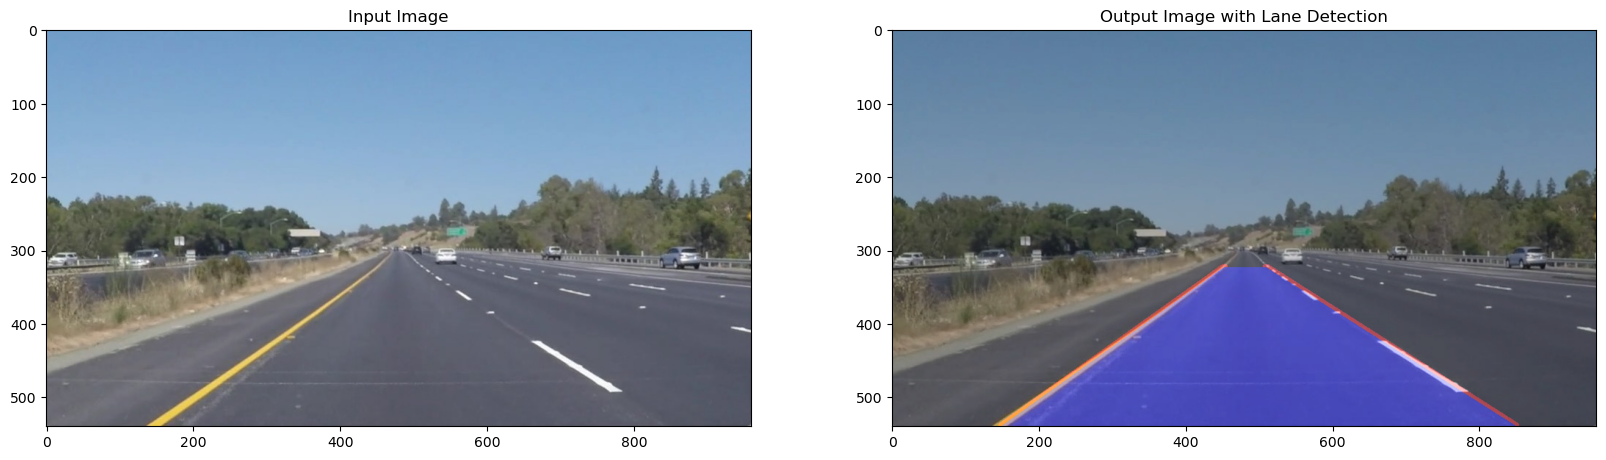

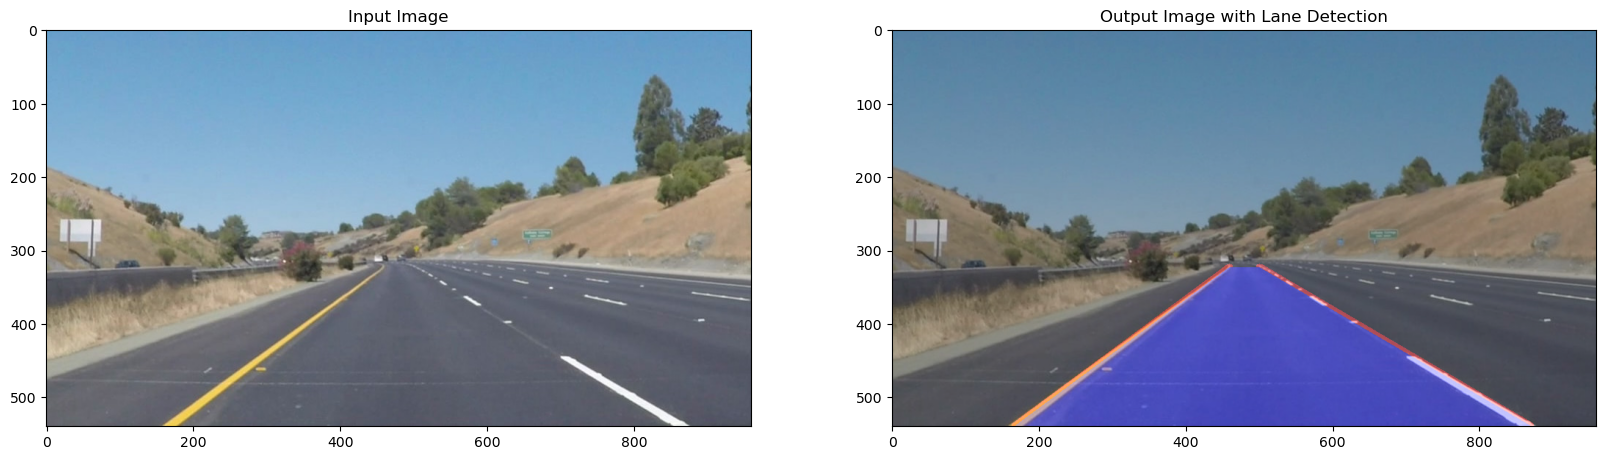

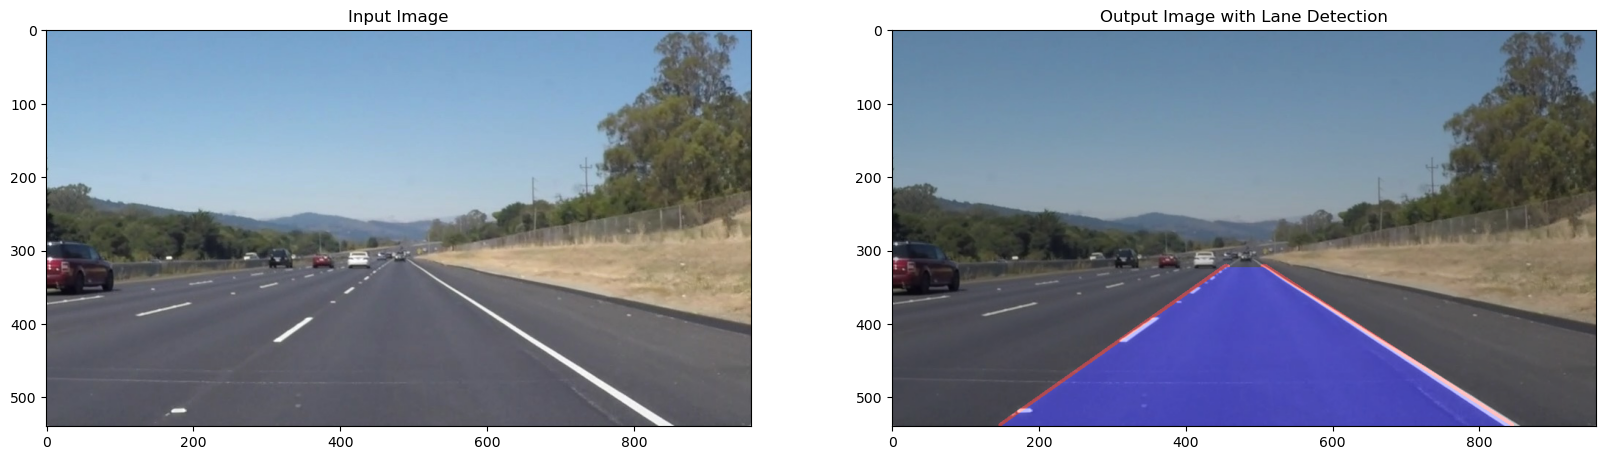

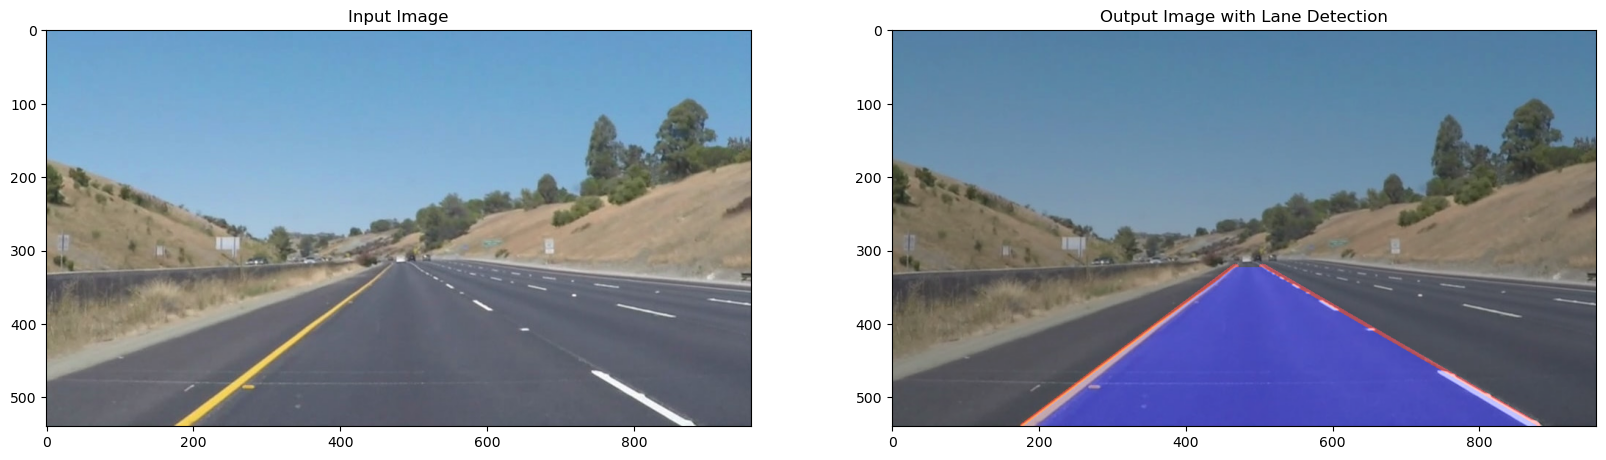

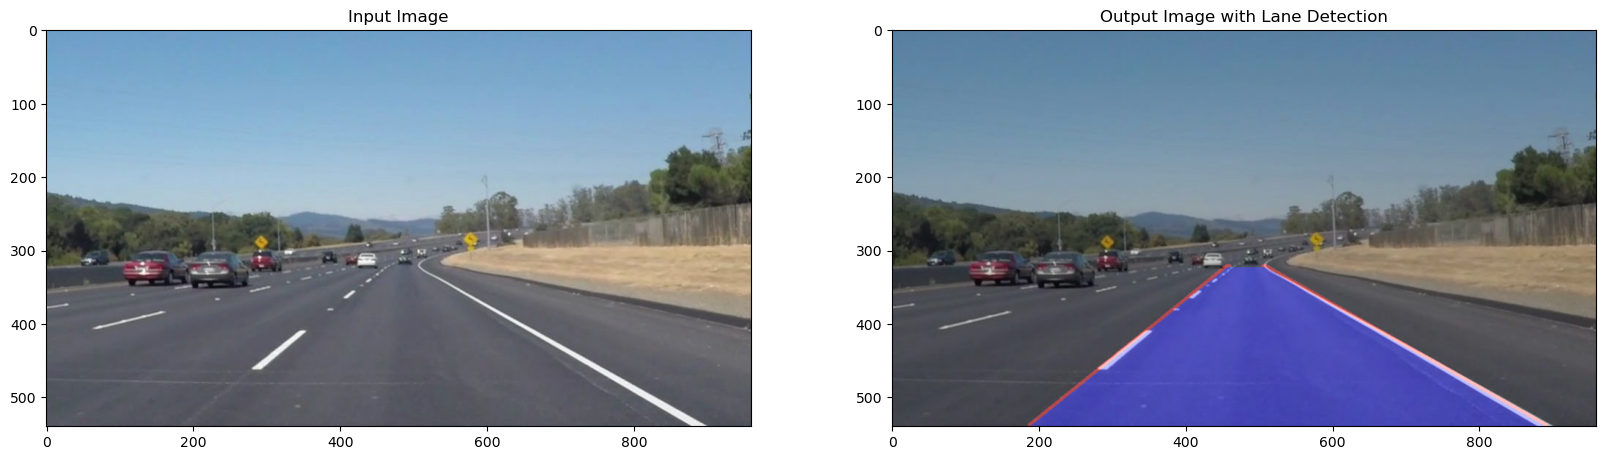

In [12]:
# Change the directory to the location of the test images on your PC
test_images_dir = '/Users/naeem/Desktop/Images'

# Loop through all the test images in the directory
for image_path in os.listdir(test_images_dir):
    # Read the image
    image = mpimg.imread(os.path.join(test_images_dir, image_path))

    # Create a figure to display the input and output images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(image)
    ax1.set_title('Input Image')

    # Apply the lane detection pipeline to the image and display the output
    output_image = lane_detection(image)
    ax2.imshow(output_image)
    ax2.set_title('Output Image with Lane Detection')

    plt.show()